Limb Darkening
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.2 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.2,<2.3"

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

We'll just add an 'lc' dataset

In [3]:
b.add_dataset('lc', times=np.linspace(0,1,101), dataset='lc01')

<ParameterSet: 15 parameters | contexts: compute, dataset>

Relevant Parameters
-----------------------------

`ld_func_bol` and `ld_coeffs_bol` are for bolometric limb-darkening, which is only currently used for [irradiation/reflection](./reflection_heating.ipynb).  These are per-component parameters that have context='component'.

In [4]:
print(b['ld_func_bol@primary'])

Parameter: ld_func_bol@primary@component
                       Qualifier: ld_func_bol
                     Description: Bolometric limb darkening model
                           Value: logarithmic
                         Choices: linear, logarithmic, quadratic, square_root, power



In [5]:
print(b['ld_func_bol@primary'].choices)

['linear', 'logarithmic', 'quadratic', 'square_root', 'power']


In [6]:
print(b['ld_coeffs_bol@primary'])

Parameter: ld_coeffs_bol@primary@component
                       Qualifier: ld_coeffs_bol
                     Description: Bolometric limb darkening coefficients
                           Value: [0.5 0.5]
                  Constrained by: 
                      Constrains: None
                      Related to: None



All other limb-darkening parameter (`ld_func`, `ld_coeffs_source`, and `ld_coeffs`) are per-component and per-dataset parameters with context='dataset'.

Unlike bolometric limb-darkening, these can be interpolated directly from atmosphere tables, this is the default case, with `ld_func` set to 'interp'.

In [6]:
print(b['ld_func@lc01'])

ParameterSet: 2 parameters
    ld_func@primary@lc01@dataset: interp
  ld_func@secondary@lc01@dataset: interp


In [7]:
print(b['ld_func@lc01@primary'].choices)

['interp', 'linear', 'logarithmic', 'quadratic', 'square_root', 'power']


Note that `ld_coeffs_source` and `ld_coeffs` aren't visible (relevant) if ld_func=='interp'

In [8]:
print(b.filter(qualifier='ld*', dataset='lc01'))

ParameterSet: 2 parameters
    ld_func@primary@lc01@dataset: interp
  ld_func@secondary@lc01@dataset: interp


Setting the value of `ld_func` to anything other than 'interp' will expose the `ld_coeffs_source` parameter.  Note that this behavior is slightly new as of PHOEBE 2.2 (see [this explanation for migrating from earlier versions](./21_22_ld_coeffs_source.ipynb)).

In [9]:
b['ld_func@lc01@primary'] = 'logarithmic'

In [10]:
print(b.filter(qualifier='ld*', dataset='lc01'))

ParameterSet: 3 parameters
    ld_func@primary@lc01@dataset: logarithmic
  ld_func@secondary@lc01@dataset: interp
  ld_coeffs_source@primary@lc...: auto


In [11]:
print(b['ld_coeffs_source@lc01@primary'])

Parameter: ld_coeffs_source@primary@lc01@dataset
                       Qualifier: ld_coeffs_source
                     Description: Source for limb darkening coefficients ('none' to provide manually, 'auto' to interpolate from the applicable table according to the 'atm' parameter, or the name of a specific atmosphere table)
                           Value: auto
                         Choices: none, auto, ck2004
                 Only visible if: ld_func:!interp



If `ld_coeffs_source` is 'auto' (which it is by default), then the limb-darkening will be interpolated **per-element** (for PHOEBE 2, other backends may interpolate per-star) for the function given in `ld_func` from the atmosphere table dictated by the `atm` parameter (falling back on 'ck2004' if no match is found).

To manually choose an available atmosphere table, you can choose some other value ('ck2004', for example).

If `ld_coeffs_source` is 'none', then the `ld_coeffs` parameter is exposed and limb-darkening coefficients can be provided directly by the user.

In [12]:
b['ld_coeffs_source@lc01@primary'] = 'none'

In [13]:
print(b.filter(qualifier='ld*', dataset='lc01'))

ParameterSet: 4 parameters
    ld_func@primary@lc01@dataset: logarithmic
  ld_func@secondary@lc01@dataset: interp
  ld_coeffs_source@primary@lc...: none
  ld_coeffs@primary@lc01@dataset: [0.5 0.5]


In [14]:
print b['ld_coeffs@lc01@primary']

Parameter: ld_coeffs@primary@lc01@dataset
                       Qualifier: ld_coeffs
                     Description: Limb darkening coefficients
                           Value: [0.5 0.5]
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: ld_func:!interp,ld_coeffs_source:none



Influence on Light Curves (fluxes)
--------------------------

In [15]:
b.run_compute(model='mymodel')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

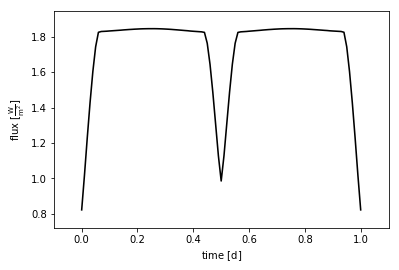

In [16]:
afig, mplfig = b['lc01@mymodel'].plot(show=True)